# Workshop #4. Statistical analysis of bulk RNA-seq

### Daniil Bobrovskiy, tg @daniilbobrovskiy

## Introduction

In this tutorial, we will analyze the bulk RNA-seq data from Walker et al., Scientific reports 2019 ([10.1038/s41598-019-56955-1](https://doi.org/10.1038/s41598-019-56955-1)). The goal of this study was to evaluate the changes in gene expression that occur during fibroblast to myofibroblast transdifferentiation in lungs. This transdifferentiation is known to occur in asthma and other lung diseases. Since it is also known that TGF-β can cause this process, the authors treated a culture of human lung fibroblasts with TGF-β to induce transdifferentiation.

The data consists of 12 samples from the cultured cells: 6 treated and 6 untreated with TGF-β. In each group, 3 samples were sequenced at day 1 after seeding cells and treating with TGF-β, while 3 other samples - at day 10.

Let's download the count matrix, which was already preprocessed by the authors, from the Gene Expression Omnibus (GEO).

It is important to note that a proper way to analyse RNA-seq data is to quantify the level of expression of different transcripts separately. After that, if the relative abundance of different isoforms is not of primary interest, the data can be aggregated to the gene-wise level, taking isoform lengths into account.

There is an amazing tool to perform this aggregation, no matter which transcript quantification tool you have used. It is an R library **tximport**, which **you should always use in your RNA-seq analysis**. Its tutorial tells you how to import quantification results from different tools (salmon/kallisto/RSEM/...) and how to pass tximport resuts into downstream libraries for differential expression analysis (edgeR/DESeq2/limma-voom): https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html.

However, the authors of the paper have simply calculated the counts for different genes and we will have to use this data in our tutorial.

In [ ]:
# download data
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110021/suppl/GSE110021%5Fcounts.Aug2015.txt.gz

# unzip count matrices
!gunzip GSE110021_counts.Aug2015.txt.gz

Now, we will install and load the required packages. One of them is Rpy2, which allows us to work in R from GoogleColab. Actually, it even allows to pass the objects between Python and R, but we won't use this feature in this tutorial.

In [ ]:
!echo "deb http://security.ubuntu.com/ubuntu focal-security main" | sudo tee /etc/apt/sources.list.d/focal-security.list
!apt-get update
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libssl1.1

!pip install --upgrade gdown
!gdown 1XAbJa_suP-WFTKK628oM9EWsV7k-6fI9
!gdown 1Bt4HDrZqFId_7Ph99pSvhfFHxyrV-kaL
!tar xf library.tar.gz

In [ ]:
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("VennDiagram")'

In [5]:
%%R
suppressPackageStartupMessages({
  library(ggplot2)
  library(ggrepel)
  library(stringr)
  library(dplyr)
  library(edgeR)
})

## Differential expression in edgeR

Another preprocessing step that is often done prior to DE analysis is the removal of all non-coding RNAs. If you want to do it, the easiest way is to load the transcript annotations corresponding to your transcriptome/genome versions from BioMart (https://www.ensembl.org/info/data/biomart/index.html). Often, if your data were mapped using not the latest annotation version, you should first go to Ensembl Archive (https://www.ensembl.org/info/website/archives/index.html), find a matching version and open BioMart from there.

In BioMart, you should select "Gene type" in the desired exported attributes together with the IDs needed to match your data to the resulting table. Once you obtained the table, you can simply filter your dataset to contain only "protein_coding" genes.

In addition to that, it is often desirable to convert unreadable ENSEMBL IDs to conventional gene names. This can be done by including the "Gene name" attribute to the BioMart export.

In [6]:
%%R
# load data; since the authors didn't merge the lanes, we'll have to do it ourselves
counts <- read.table("GSE110021_counts.Aug2015.txt")
counts <- data.frame(D1_cont_1=rowSums(select(counts, starts_with("D1.noTGFb.1"))),
                     D1_cont_2=rowSums(select(counts, starts_with("D1.noTGFb.2"))),
                     D1_cont_3=rowSums(select(counts, starts_with("D1.noTGFb.3"))),
                     D1_tgf_1=rowSums(select(counts, starts_with("D1.TGFb.1"))),
                     D1_tgf_2=rowSums(select(counts, starts_with("D1.TGFb.2"))),
                     D1_tgf_3=rowSums(select(counts, starts_with("D1.TGFb.3"))),
                     D20_cont_1=rowSums(select(counts, starts_with("D20.noTGFb.1"))),
                     D20_cont_2=rowSums(select(counts, starts_with("D20.noTGFb.2"))),
                     D20_cont_3=rowSums(select(counts, starts_with("D20.noTGFb.3"))),
                     D20_tgf_1=rowSums(select(counts, starts_with("D20.TGFb.1"))),
                     D20_tgf_2=rowSums(select(counts, starts_with("D20.TGFb.2"))),
                     D20_tgf_3=rowSums(select(counts, starts_with("D20.TGFb.3"))))

Let's load the table I pre-downloaded from BioMart

In [7]:
%%R
biomart <- read.table("biomart_hg19_ensembl75.tsv", sep="\t", header=TRUE)
str(biomart)

'data.frame':	233303 obs. of  7 variables:
 $ Gene.stable.ID                    : chr  "ENSG00000261657" "ENSG00000261657" "ENSG00000261657" "ENSG00000261657" ...
 $ Gene.stable.ID.version            : chr  "ENSG00000261657.1" "ENSG00000261657.1" "ENSG00000261657.1" "ENSG00000261657.1" ...
 $ Transcript.stable.ID              : chr  "ENST00000566782" "ENST00000562780" "ENST00000569579" "ENST00000568242" ...
 $ Transcript.stable.ID.version      : chr  "ENST00000566782.1" "ENST00000562780.1" "ENST00000569579.1" "ENST00000568242.1" ...
 $ NCBI.gene..formerly.Entrezgene..ID: int  115286 115286 115286 115286 115286 NA NA NA NA 100873766 ...
 $ Gene.name                         : chr  "SLC25A26" "SLC25A26" "SLC25A26" "SLC25A26" ...
 $ Gene.type                         : chr  "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...


In [8]:
%%R
protein_coding <- biomart$Gene.type[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)] == "protein_coding"
protein_coding[is.na(protein_coding)] <- FALSE
counts <- counts[protein_coding,]
ensembl <- biomart$Gene.stable.ID[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)]
symbol <- biomart$Gene.name[match(rownames(counts), biomart$NCBI.gene..formerly.Entrezgene..ID)]
str(counts)

'data.frame':	19016 obs. of  12 variables:
 $ D1_cont_1 : num  0 0 0 3 1394 ...
 $ D1_cont_2 : num  0 0 0 27 1522 ...
 $ D1_cont_3 : num  0 0 0 4 1281 ...
 $ D1_tgf_1  : num  0 0 0 14 954 109 23 9 11 131 ...
 $ D1_tgf_2  : num  0 0 0 26 1861 ...
 $ D1_tgf_3  : num  0 0 0 11 920 92 25 4 11 133 ...
 $ D20_cont_1: num  0 0 0 15 680 113 26 4 20 230 ...
 $ D20_cont_2: num  0 0 0 32 865 169 26 6 27 329 ...
 $ D20_cont_3: num  0 0 0 14 999 182 40 11 25 384 ...
 $ D20_tgf_1 : num  0 0 0 40 1187 ...
 $ D20_tgf_2 : num  0 0 0 22 681 103 30 4 5 202 ...
 $ D20_tgf_3 : num  0 0 0 11 700 133 35 3 6 174 ...


Let's use principal component analysis to visualize overall differences between our samples

In [ ]:
%%R
# scale the data
counts_scaled <- t(scale(counts))

# run PCA
pca_result <- prcomp(counts_scaled, center = TRUE, scale. = TRUE)
variance_explained <- pca_result$sdev^2 / sum(pca_result$sdev^2) * 100

# extract first two PCs
scores_df <- data.frame(PC1 = pca_result$x[,1], PC2 = pca_result$x[,2])
scores_df$Sample = row.names(scores_df)
groups <- str_remove(scores_df$Sample, "_[0-9]+$")
scores_df$group = groups

# plot first two PCs
ggplot(scores_df, aes(x = PC1, y = PC2, label = Sample, color = group)) +
  geom_point(size=2) +
  geom_text_repel(size=5,
                  box.padding = 0.5,
                  point.padding = 0.5,
                  max.overlaps = Inf)+
  theme_minimal()+
  theme(legend.position = "none")+
  labs(x=paste("PC1 (", sprintf("%.1f", variance_explained[1]), "%)", sep=""),,
       y=paste("PC2 (", sprintf("%.1f", variance_explained[2]), "%)", sep=""),)

Loading our counts into edgeR and adding information about the groups

In [18]:
%%R
y <- DGEList(counts=counts, group=groups)
design <- model.matrix(~0+groups)
colnames(design) <- str_remove(colnames(design), "groups")
design

   D1_cont D1_tgf D20_cont D20_tgf
1        1      0        0       0
2        1      0        0       0
3        1      0        0       0
4        0      1        0       0
5        0      1        0       0
6        0      1        0       0
7        0      0        1       0
8        0      0        1       0
9        0      0        1       0
10       0      0        0       1
11       0      0        0       1
12       0      0        0       1
attr(,"assign")
[1] 1 1 1 1
attr(,"contrasts")
attr(,"contrasts")$groups
[1] "contr.treatment"



## Further work with edgeR

In [19]:
%%R
str(y)

Formal class 'DGEList' [package "edgeR"] with 1 slot
  ..@ .Data:List of 2
  .. ..$ : num [1:19016, 1:12] 0 0 0 3 1394 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:19016] "79501" "729759" "81399" "148398" ...
  .. .. .. ..$ : chr [1:12] "D1_cont_1" "D1_cont_2" "D1_cont_3" "D1_tgf_1" ...
  .. ..$ :'data.frame':	12 obs. of  3 variables:
  .. .. ..$ group       : Factor w/ 4 levels "D1_cont","D1_tgf",..: 1 1 1 2 2 2 3 3 3 4 ...
  .. .. ..$ lib.size    : num [1:12] 11357597 14438232 11365167 8542486 17900836 ...
  .. .. ..$ norm.factors: num [1:12] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ names: chr [1:2] "counts" "samples"


Filtering low-expressed genes

In [20]:
%%R
keep <- filterByExpr(y, design=design, min.count=10, min.total.count=100, min.prop=0.25)
y <- y[keep, , keep.lib.sizes=FALSE]
y$genes <- data.frame(Ensembl=ensembl, Symbol=symbol)
str(y)

Formal class 'DGEList' [package "edgeR"] with 1 slot
  ..@ .Data:List of 3
  .. ..$ : num [1:12354, 1:12] 3 1394 164 27 12 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:12354] "148398" "26155" "339451" "84069" ...
  .. .. .. ..$ : chr [1:12] "D1_cont_1" "D1_cont_2" "D1_cont_3" "D1_tgf_1" ...
  .. ..$ :'data.frame':	12 obs. of  3 variables:
  .. .. ..$ group       : Factor w/ 4 levels "D1_cont","D1_tgf",..: 1 1 1 2 2 2 3 3 3 4 ...
  .. .. ..$ lib.size    : num [1:12] 11351867 14429978 11359967 8538244 17891947 ...
  .. .. ..$ norm.factors: num [1:12] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ :'data.frame':	19016 obs. of  2 variables:
  .. .. ..$ Ensembl: chr [1:19016] "ENSG00000186092" "ENSG00000235249" "ENSG00000235249" "ENSG00000187634" ...
  .. .. ..$ Symbol : chr [1:19016] "OR4F5" "OR4F29" "OR4F29" "SAMD11" ...
  ..$ names: chr [1:3] "counts" "samples" "genes"


Compute effective library sizes (see lecture)

In [ ]:
%%R
y <- calcNormFactors(y) # called normLibSizes in newer versions
str(y)

Formal class 'DGEList' [package "edgeR"] with 1 slot
  ..@ .Data:List of 3
  .. ..$ : num [1:12354, 1:12] 3 1394 164 27 12 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:12354] "148398" "26155" "339451" "84069" ...
  .. .. .. ..$ : chr [1:12] "D1_cont_1" "D1_cont_2" "D1_cont_3" "D1_tgf_1" ...
  .. ..$ :'data.frame':	12 obs. of  3 variables:
  .. .. ..$ group       : Factor w/ 4 levels "D1_cont","D1_tgf",..: 1 1 1 2 2 2 3 3 3 4 ...
  .. .. ..$ lib.size    : num [1:12] 11351867 14429978 11359967 8538244 17891947 ...
  .. .. ..$ norm.factors: num [1:12] 1.013 1.029 1.015 0.973 0.965 ...
  .. ..$ :'data.frame':	19016 obs. of  2 variables:
  .. .. ..$ Ensembl: chr [1:19016] "ENSG00000186092" "ENSG00000235249" "ENSG00000235249" "ENSG00000187634" ...
  .. .. ..$ Symbol : chr [1:19016] "OR4F5" "OR4F29" "OR4F29" "SAMD11" ...
  ..$ names: chr [1:3] "counts" "samples" "genes"


Compared to what we discussed in the lecture, the variance of the counts in edgeR has a slightly more complicated form. It contains both the common dispersion component for all of the genes $\phi$, and the gene-wise dispersion component $\sigma_g$:

$Var(y_{ig}) = σ^2_g(\mu_{ig} + \phi \mu^2_{ig}),$ $i$ - sample, $g$ - gene.

First, the common dispersion $\phi$ is evaluated. Then, the trend for the gene-wise dispersions is computed as discussed in the lecture. Finally, the gene-wise dispersions are estimated and squeezed towards that trend.

In [ ]:
%%R
y <- estimateDisp(y, design)
# this is equivalent to:
# y <- estimateGLMCommonDisp(y, design)
# y <- estimateGLMTrendedDisp(y, design)
# y <- estimateGLMTagwiseDisp(y, design)

Now let's tell edgeR, which groups we want to compare

In [ ]:
%%R
fit <- glmQLFit(y, design)
contrasts <- makeContrasts(
  cont_20vs1 = D20_cont - D1_cont,
  tgf_20vs1 = D20_tgf - D1_tgf,
  d1_tgf = D1_tgf - D1_cont,
  d20_tgf = D20_tgf - D20_cont,
  levels=design)

In [ ]:
%%R
contrasts

          Contrasts
Levels     cont_20vs1 tgf_20vs1 d1_tgf d20_tgf
  D1_cont          -1         0     -1       0
  D1_tgf            0        -1      1       0
  D20_cont          1         0      0      -1
  D20_tgf           0         1      0       1


For example, the contrast `cont_20vs1` signifies a statistical test for the null hypothesis that `D20_cont - D1_cont = 0`.

In [ ]:
%%R
qlf_cont_20vs1 <- glmQLFTest(fit, contrast=contrasts[,"cont_20vs1"])
qlf_tgf_20vs1 <- glmQLFTest(fit, contrast=contrasts[,"tgf_20vs1"])
qlf_d1_tgf <- glmQLFTest(fit, contrast=contrasts[,"d1_tgf"])
qlf_d20_tgf <- glmQLFTest(fit, contrast=contrasts[,"d20_tgf"])

In [ ]:
%%R
print(summary(decideTests(qlf_cont_20vs1)))
print(summary(decideTests(qlf_tgf_20vs1)))
print(summary(decideTests(qlf_d1_tgf)))
print(summary(decideTests(qlf_d20_tgf)))

       -1*D1_cont 1*D20_cont
Down                    2884
NotSig                  6468
Up                      3002
       -1*D1_tgf 1*D20_tgf
Down                  2928
NotSig                6524
Up                    2902
       -1*D1_cont 1*D1_tgf
Down                  1364
NotSig                9665
Up                    1325
       -1*D20_cont 1*D20_tgf
Down                    2469
NotSig                  7539
Up                      2346


The smallest number of DE genes is found between the TGF-β-treated and untreated cells on day 1, which is expected.

In [ ]:
%%R
qlftab_cont_20vs1 <- topTags(qlf_cont_20vs1, n=nrow(y))$table
qlftab_tgf_20vs1 <- topTags(qlf_tgf_20vs1, n=nrow(y))$table
qlftab_d1_tgf <- topTags(qlf_d1_tgf, n=nrow(y))$table
qlftab_d20_tgf <- topTags(qlf_d20_tgf, n=nrow(y))$table

In [ ]:
%%R
head(qlftab_cont_20vs1)

              Ensembl   Symbol     logFC   logCPM        F       PValue
6328  ENSG00000103018    CYB5B  5.912420 2.421628 596.3106 6.715974e-13
6574  ENSG00000159625  CCDC135 -1.631513 8.349429 578.4268 8.277230e-13
25907 ENSG00000141524     TMC6 -1.623484 8.716842 466.0209 3.632401e-12
9700  ENSG00000023191     RNH1 -2.758252 3.685243 451.7046 4.494145e-12
10212 ENSG00000186073 C15orf41 -1.630497 5.433907 408.9434 8.846526e-12
991   ENSG00000142733   MAP3K6 -3.224106 5.439792 404.8024 9.480323e-12
               FDR
6328  5.112845e-09
6574  5.112845e-09
25907 1.388017e-08
9700  1.388017e-08
10212 1.707764e-08
991   1.707764e-08


Let's visualize, which DE genes are common between different comparisons

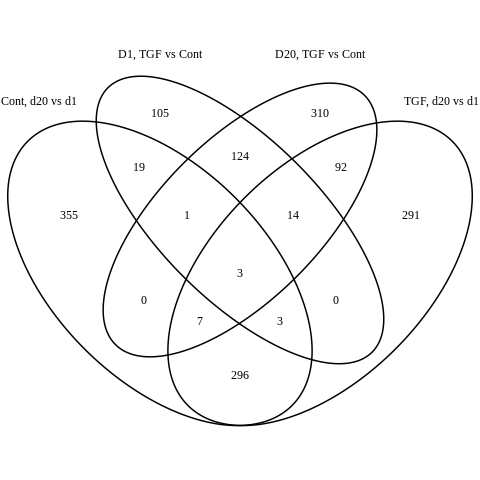

In [ ]:
%%R
# Filter DE Genes based on FDR < 0.05 and logFC > 2
de_genes_cont_20vs1 <- subset(qlftab_cont_20vs1, FDR < 0.05 & logFC > 1)$Symbol
de_genes_tgf_20vs1 <- subset(qlftab_tgf_20vs1, FDR < 0.05 & logFC > 1)$Symbol
de_genes_d1_tgf <- subset(qlftab_d1_tgf, FDR < 0.05 & logFC > 1)$Symbol
de_genes_d20_tgf <- subset(qlftab_d20_tgf, FDR < 0.05 & logFC > 1)$Symbol

# Use VennDiagram package to plot the Venn diagram
library(VennDiagram)
venn.plot <- venn.diagram(
  x = list(
    Cont_20vs1 = de_genes_cont_20vs1,
    TGF_20vs1 = de_genes_tgf_20vs1,
    D1_TGF = de_genes_d1_tgf,
    D20_TGF = de_genes_d20_tgf
  ),
  category.names = c("Cont, d20 vs d1", "TGF, d20 vs d1", "D1, TGF vs Cont", "D20, TGF vs Cont"),
  filename = NULL
)
grid.draw(venn.plot)

And now we plot a **volcano plot** for one of the comparisons! This is useful to identify genes which have both large changes in expression (large logFC) and these changes are significant (large -log10(P-value)).

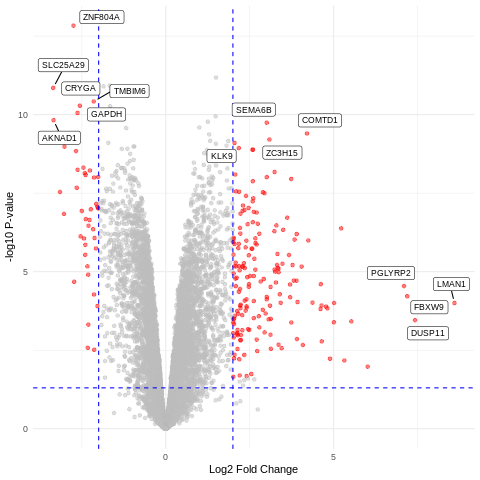

In [ ]:
%%R
# ad
qlftab_tgf_20vs1$p_log10 <- -log10(qlftab_tgf_20vs1$PValue)

# Identify the most DE genes: (abs(logFC)>2 and -log10P>9) or (abs(logFC)>7)
top_genes <- qlftab_tgf_20vs1[((abs(qlftab_tgf_20vs1$logFC)>2)&(qlftab_tgf_20vs1$p_log10>9))|(abs(qlftab_tgf_20vs1$logFC)>7), ]

# Plot the volcano plot
ggplot(qlftab_tgf_20vs1, aes(x=logFC, y=p_log10)) +
  geom_point(aes(color = (FDR < 0.05 & abs(logFC) > 2)), alpha=0.5) +
  scale_color_manual(values = c("FALSE" = "grey", "TRUE" = "red")) +
  labs(x = "Log2 Fold Change",
       y = "-log10 P-value") +
  theme_minimal() +
  theme(legend.title = element_blank(), legend.position = "none") +
  geom_vline(xintercept = c(-2, 2), linetype = "dashed", color = "blue") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "blue") +
  geom_label_repel(data = top_genes,
                  aes(label = Symbol),
                  size = 3,
                  box.padding = unit(0.35, "lines"),
                  point.padding = unit(0.5, "lines"))

Finally, we can perform gene set enrichment analysis for this comparison using clusterProfiler package

In [ ]:
%%R
suppressPackageStartupMessages({
  library(clusterProfiler)
  library(org.Hs.eg.db)
})

In [ ]:
%%R
geneList <- qlftab_tgf_20vs1$p_log10*sign(qlftab_tgf_20vs1$logFC)
names(geneList) <- rownames(qlftab_tgf_20vs1)
geneList <- sort(geneList, decreasing = TRUE)

gsea_bp <- gseGO(geneList=geneList, ont="BP", OrgDb=org.Hs.eg.db)

In [ ]:
%%R

head(gsea_bp@result[, c("Description", "setSize", "NES", "p.adjust")])

                                           Description setSize       NES
GO:0006261               DNA-templated DNA replication     159 -2.874531
GO:0006260                             DNA replication     270 -2.685059
GO:0098813              nuclear chromosome segregation     267 -2.635281
GO:0090329 regulation of DNA-templated DNA replication      54 -2.632989
GO:0006270                  DNA replication initiation      36 -2.615843
GO:0000070        mitotic sister chromatid segregation     192 -2.612069
               p.adjust
GO:0006261 8.129851e-09
GO:0006260 8.129851e-09
GO:0098813 8.129851e-09
GO:0090329 8.129851e-09
GO:0006270 8.129851e-09
GO:0000070 8.129851e-09


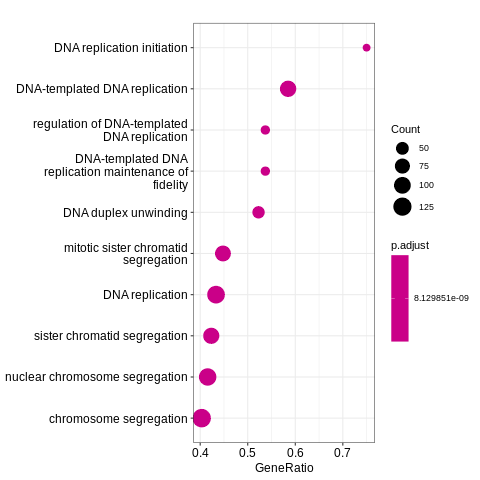

In [ ]:
%%R
dotplot(gsea_bp, showCategory=10)

## Exercise

At home, perform the same analysis with the standard DESeq2 pipeline. DESeq2 documentation is very detailed: https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html. For each step, comment, how it relates to what we did in edgeR.

You can then compare lists of differentially expressed genes between edgeR and DESeq2 using Venn diagrams or plot the p-values of different genes in edgeR and DESeq2 against each other.

And feel free to ask questions! @daniilbobrovskiy

Загружаем DESeq2 в R.

In [13]:
%%R
suppressPackageStartupMessages(library(DESeq2))

### Сделаем матрицу каунтов для DESeq2

In [53]:
%%R
dds <- DESeqDataSetFromMatrix(countData=counts,
                              colData=as.data.frame(groups),
                              design=design)
str(dds)

Formal class 'DESeqDataSet' [package "DESeq2"] with 8 slots
  ..@ design            : num [1:12, 1:4] 1 1 1 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:12] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:4] "D1_cont" "D1_tgf" "D20_cont" "D20_tgf"
  .. ..- attr(*, "assign")= int [1:4] 1 1 1 1
  .. ..- attr(*, "contrasts")=List of 1
  .. .. ..$ groups: chr "contr.treatment"
  ..@ dispersionFunction:function ()  
  ..@ rowRanges         :Formal class 'CompressedGRangesList' [package "GenomicRanges"] with 5 slots
  .. .. ..@ unlistData     :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. .. .. ..@ values         : Factor w/ 0 levels: 
  .. .. .. .. .. .. ..@ lengths        : int(0) 
  .. .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"

In [59]:
%%R
head(dds)

class: DESeqDataSet 
dim: 6 12 
metadata(1): version
assays(1): counts
rownames(6): 79501 729759 ... 26155 339451
rowData names(2): Ensembl Symbol
colnames(12): D1_cont_1 D1_cont_2 ... D20_tgf_2 D20_tgf_3
colData names(1): groups


### Аннотации

In [54]:
%%R
annotation <- biomart[match(rownames(dds), biomart$NCBI.gene..formerly.Entrezgene..ID),]

In [55]:
%%R
all(rownames(dds) == annotation$NCBI.gene..formerly.Entrezgene..ID)

[1] TRUE


In [56]:
%%R
featureData <- data.frame(Ensembl=ensembl, Symbol=symbol)
mcols(dds) <- DataFrame(mcols(dds), featureData)
#mcols(dds) <- cbind(mcols(dds), newMcols)
head(mcols(dds))

DataFrame with 6 rows and 2 columns
               Ensembl      Symbol
           <character> <character>
79501  ENSG00000186092       OR4F5
729759 ENSG00000235249      OR4F29
81399  ENSG00000235249      OR4F29
148398 ENSG00000187634      SAMD11
26155  ENSG00000188976       NOC2L
339451 ENSG00000187961      KLHL17


### Фильтрация против малого числа каунтов.

In [57]:
%%R
smallestGroupSize <- 3
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
dds_keep <- dds[keep,]
str(dds_keep)

Formal class 'DESeqDataSet' [package "DESeq2"] with 8 slots
  ..@ design            : num [1:12, 1:4] 1 1 1 0 0 0 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:12] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:4] "D1_cont" "D1_tgf" "D20_cont" "D20_tgf"
  .. ..- attr(*, "assign")= int [1:4] 1 1 1 1
  .. ..- attr(*, "contrasts")=List of 1
  .. .. ..$ groups: chr "contr.treatment"
  ..@ dispersionFunction:function ()  
  ..@ rowRanges         :Formal class 'CompressedGRangesList' [package "GenomicRanges"] with 5 slots
  .. .. ..@ unlistData     :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. .. .. ..@ values         : Factor w/ 0 levels: 
  .. .. .. .. .. .. ..@ lengths        : int(0) 
  .. .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"

### Проводим анализ с помощью DESeq2 (расчёт нормализации, дисперсий и статистических тестов он делает внутри себя)

In [61]:
%%R
res <- DESeq(dds_keep)

In [64]:
%%R
result <- results(res)
head(result)

log2 fold change (MLE): D20 tgf 
Wald test p-value: D20 tgf 
DataFrame with 6 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat       pvalue         padj
        <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
148398   17.28364        4.49275 0.3923581  11.45062  2.33459e-30  2.47687e-30
26155  1067.00087        9.67782 0.0604507 160.09441  0.00000e+00  0.00000e+00
339451  154.99217        7.14559 0.1173750  60.87831  0.00000e+00  0.00000e+00
84069    34.58942        5.11230 0.2150821  23.76909 6.97542e-125 8.00858e-125
84808     8.02696        2.53814 0.4533447   5.59870  2.15968e-08  2.18447e-08
57801    16.01470        2.90233 0.4243425   6.83959  7.94216e-12  8.09829e-12


In [73]:
%%R
summary(result)


out of 12606 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 12589, 100%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 2, 0.016%
low counts [2]     : 0, 0%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



### Визуализация с помощью графиков

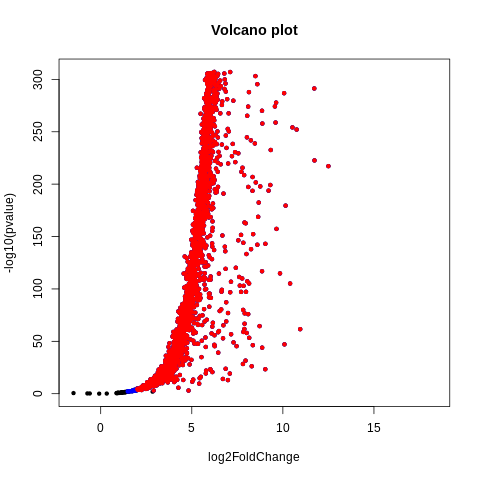

In [70]:
%%R

par(mfrow=c(1,1))
# Make a basic volcano plot
with(result, plot(log2FoldChange, -log10(pvalue), pch=20, main="Volcano plot"))

# Add colored points: blue if padj<0.01, red if log2FC>1 and padj<0.05)
with(subset(result, padj<.01 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(result, padj<.01 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))